# Pairs Trading

**UI Suggestions:**
- Build a UI that includes three key components (1) a chat-bot responds to user's questions with George Soros' investment insights (2) a dashboard to allow users to (1) **optionally choose whether they want to check** if there exists cointegration between any pair of stocks, **please see the cointegration test part below** (2) select the time range they want to back-test the trading performance of their self-selected stock pairs. (3) visualize the spread dynamics, using the pairs trading model I wrote for you you below.
- Ideally, users should be able to caculate and report the profits and losses from taking the pairs-trading strategy as shown in the second figure below.  

**50 well-known pairs That Hedge Funds implement in Pairs Trading Algo**
- https://medium.com/@tzjy/50-well-known-pairs-that-hedge-funds-implement-in-pairs-trading-algo-ce7e8e449a76

**A cointegration test** is a statistical method used to determine whether two or more non-stationary time series are linked by a stationary time-series. In simple terms: Even if two time series that individually trend over time may not have constant mean or volatility, they might still move together in such a way that their difference (i.e., the spread from a linear combination) has a mean-reversion pattern. You can use the statsmodels library's coint() function for the Engle-Granger two-step cointegration test.

In [5]:
import pandas as pd
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Download historical data for two correlated stocks
# spread = y - X*beta
stock1 = "XOM" # ExxonMobil (XOM)   
stock2 = "CVX" # Chevron (CVX)

start_date = "2023-01-01"
end_date = "2023-12-31"

data = yf.download([stock1, stock2], start=start_date, end=end_date)['Close']

# Calculate the spread
X = data[stock1]
y = data[stock2]

# Perform cointegration test
score, p_value, _ = coint(X, y)

print("Cointegration Test Results:")
print(f"Test Statistic: {score}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("✅ The two series are cointegrated (reject the null hypothesis).")
else:
    print("❌ The two series are NOT cointegrated (fail to reject the null hypothesis).")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed

Cointegration Test Results:
Test Statistic: -3.36547164611105
P-Value: 0.04633285567436993
✅ The two series are cointegrated (reject the null hypothesis).


Notes:
- Null hypothesis (H0): No cointegration.
- Alternative hypothesis (H1): The series are cointegrated.
- A low p-value (< 0.05) means you can reject H₀ and conclude that the series are cointegrated.

**Pairs Trading** is a market-neutral strategy that involves identifying two historically correlated stocks, monitoring their price divergence, and executing trades to profit from the expected reversion to the mean. Below is a simple Python example demonstrating how pairs trading works using historical stock data with the yfinance library and statsmodels for statistical analysis.

[*********************100%***********************]  2 of 2 completed


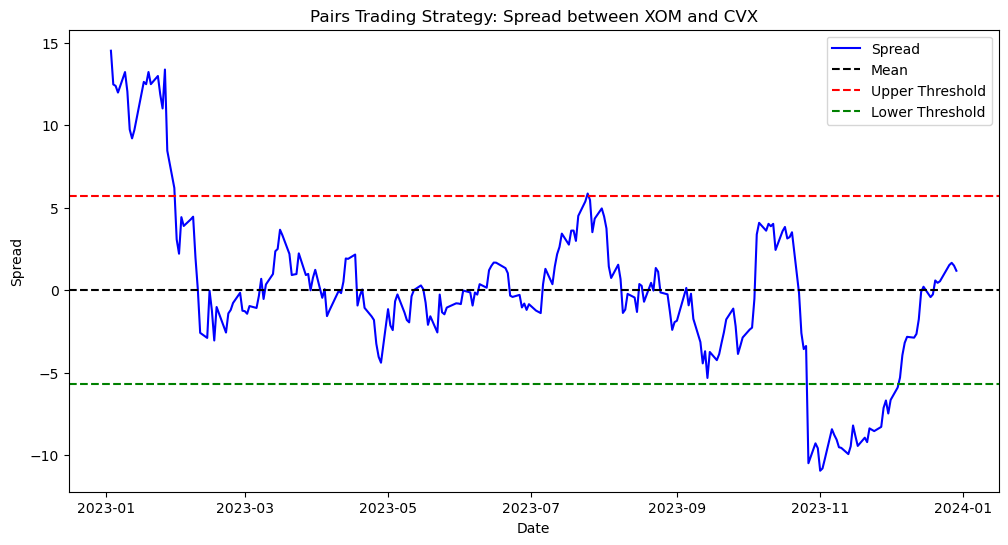

Total Profit/Loss from strategy: 0.04548430365758127


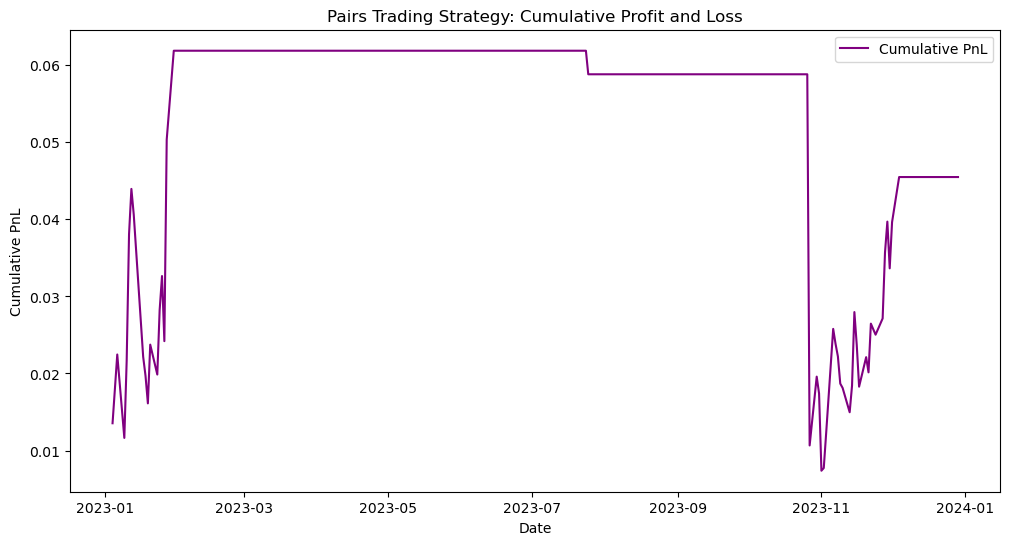

Ticker        spread   long  short       pnl  cumulative_pnl
Date                                                        
2023-11-16 -8.830708   True  False -0.004251        0.023716
2023-11-17 -9.431301   True  False -0.005426        0.018291
2023-11-20 -8.932052   True  False  0.003829        0.022120
2023-11-21 -9.200678   True  False -0.001973        0.020147
2023-11-22 -8.367294   True  False  0.006321        0.026468
2023-11-24 -8.532355   True  False -0.001435        0.025033
2023-11-27 -8.276798   True  False  0.002107        0.027140
2023-11-28 -7.124597   True  False  0.008544        0.035684
2023-11-29 -6.676244   True  False  0.004019        0.039702
2023-11-30 -7.465919   True  False -0.006063        0.033640
2023-12-01 -6.644483   True  False  0.005993        0.039633
2023-12-04 -5.889289   True  False  0.005852        0.045484
2023-12-05 -5.288277  False  False  0.000000        0.045484
2023-12-06 -3.937337  False  False  0.000000        0.045484
2023-12-07 -3.179125  Fa

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Download historical data for two correlated stocks
# spread = y - X*beta
stock1 = "XOM" # ExxonMobil (XOM)   
stock2 = "CVX" # Chevron (CVX)

start_date = "2023-01-01"
end_date = "2023-12-31"

data = yf.download([stock1, stock2], start=start_date, end=end_date)['Close']

# Calculate the spread
X = data[stock1]
y = data[stock2]
X = sm.add_constant(X)  # Add a constant for OLS regression

model = sm.OLS(y, X).fit()
data['spread'] = y - model.predict(X)

# Define thresholds for trading (mean and standard deviation of the spread)
mean_spread = data['spread'].mean()
std_spread = data['spread'].std()
c = 1.18
upper_threshold = mean_spread + c*std_spread
lower_threshold = mean_spread - c*std_spread

# Plot the spread and trading signals
plt.figure(figsize=(12,6))
plt.plot(data.index, data['spread'], label='Spread', color='blue')
plt.axhline(mean_spread, color='black', linestyle='--', label='Mean')
plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title('Pairs Trading Strategy: Spread between {} and {}'.format(stock1, stock2))
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

# Simulate trading signals
data['long'] = data['spread'] < lower_threshold  # Buy the spread (long underpriced, short overpriced)
data['short'] = data['spread'] > upper_threshold  # Short the spread (short overpriced, long underpriced)

# Calculate daily returns for each stock
data['returns_stock1'] = data[stock1].pct_change()
data['returns_stock2'] = data[stock2].pct_change()

# Calculate PnL assuming equal weighting in each trade
data['pnl'] = np.where(data['long'], data['returns_stock2'] - data['returns_stock1'], 0) + \
              np.where(data['short'], data['returns_stock1'] - data['returns_stock2'], 0)

# Cumulative PnL
data['cumulative_pnl'] = data['pnl'].cumsum()

# Display final PnL
print("Total Profit/Loss from strategy:", data['cumulative_pnl'].iloc[-1])

# Plot cumulative PnL
plt.figure(figsize=(12,6))
plt.plot(data.index, data['cumulative_pnl'], label='Cumulative PnL', color='purple')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Pairs Trading Strategy: Cumulative Profit and Loss')
plt.legend()
plt.show()

# Display trading signals and PnL during the last 30 trading days
print(data[['spread', 'long', 'short', 'pnl', 'cumulative_pnl']].tail(30))